# Code conventions used
    - camelCase for objects and user-defined functions
    - snake_case for variables
    - Double  quotes over single quotes
    - Tabs over spaces

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

In [2]:
# load data
loans = pd.read_csv("../../Data/loan.csv")

/home/peekay-kun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# information of the loan dataset
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


Since there are a lot of variables with a lot of values missing, a good place to start would be to look at those missing values.

In [4]:
# missing values in columns
loans.isnull().mean().sort_values(ascending = False)

total_il_high_credit_limit     1.0
mo_sin_old_rev_tl_op           1.0
bc_util                        1.0
bc_open_to_buy                 1.0
avg_cur_bal                    1.0
acc_open_past_24mths           1.0
inq_last_12m                   1.0
total_cu_tl                    1.0
inq_fi                         1.0
total_rev_hi_lim               1.0
all_util                       1.0
max_bal_bc                     1.0
open_rv_24m                    1.0
open_rv_12m                    1.0
il_util                        1.0
total_bal_il                   1.0
mths_since_rcnt_il             1.0
open_il_24m                    1.0
open_il_12m                    1.0
open_il_6m                     1.0
open_acc_6m                    1.0
tot_cur_bal                    1.0
tot_coll_amt                   1.0
total_bc_limit                 1.0
dti_joint                      1.0
annual_inc_joint               1.0
mths_since_last_major_derog    1.0
mo_sin_old_il_acct             1.0
verification_status_

Generally, a good way to reduce the dimensionality of the data would be to get rid of all columns with more than a certain percentage of missing values. Industry recommended standards range from 6%-10% (ref. Practical Data Science with R). But, this dataset has a lot of columns with way more missing values. So, 15% would be a better cut-off point.

In [5]:
# dropping columns with more than 15% values missing
loans.drop(loans.columns[loans.isnull().mean() > 0.15], axis = 1, inplace = True)

Another variable that can be dropped is the member id. This is just an id variable and the loan id can be used in lieu of this. So, it's better to drop it off.

In [6]:
# dropping member id
loans.drop(["member_id"], axis = 1, inplace = True)

In [7]:
# list of columns in the dataset
loans.columns.sort_values()

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id',
       'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate',
       'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d',
       'loan_amnt', 'loan_status', 'open_acc', 'out_prncp', 'out_prncp_inv',
       'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose',
       'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'sub_grade',
       'tax_liens', 'term', 'title', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'url', 'verification_status', 'zip_code'],
      dtype='object')

Since there are too many columns, sizing down and focusing on a few relevant columns would be better. So, the following columns will be selected for a detailed analysis:
    [Mention columns considered for analysis]

In [8]:
# subsetting the columns required for analysis
analysis_columns = ["loan_status","purpose", "funded_amnt", "total_rec_prncp", "home_ownership", "term",
                "installment", "dti", "recoveries", "int_rate", "addr_state", "id"]
loans_final = loans.loc[:, analysis_columns].copy()

Each of the sections below will be reserved for the analysis of one particular variable. The section titles will indicate which variable is being analyzed.

# Interest Rate
The general conclusion is that higher a loan's interest rate, greater the number of defaulters. Is this true for the current dataset? Are there statistically significant differences among the interest rates of loans on which the borrowers did and did not default? 

Answering these questions is going to be the aim of this section.

First off, there's a problem with working on the interest rates as they are. The numerical value of the interest rates is followed by the "%" symbol. It's better to remove that, convert interest rate to a numeric var and analyze it.

In [9]:
# converting loans_final.int_rate to float32
loans_final["int_rate"] = loans_final["int_rate"].str.replace("%", "")
loans_final["int_rate"] = loans_final["int_rate"].astype("float32")

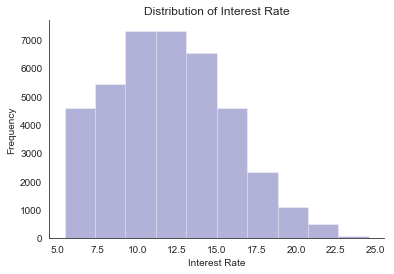

In [10]:
# distribution of interest rate
plt.hist(loans_final["int_rate"], alpha = 0.3, color = "navy")
plt.title("Distribution of Interest Rate")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
sns.despine()
plt.show()

The distribution of interest rate for the loans that were charged off seem to follow a normal distribution. It'd be a good action to test that observation as it would help a lot during the modeling / hypothesis testing stage. 

To do that, a comparison with the cdf of a corresponding normal distribution would be helpful.

In [11]:
# # function to get cdf of the variable
def evalCdf(ts, x):
    count = 0
    for t in ts:
        if x > t:
            count += 1
    return count /  len(ts)

In [12]:
data = loans_final["int_rate"]
data_cdf = data.apply(lambda x: evalCdf(data, x = x))

model = np.random.normal(loc = data.mean(), scale = data.std(), size = data.shape[0])
model_cdf = [evalCdf(ts = model, x = i) for i in model]

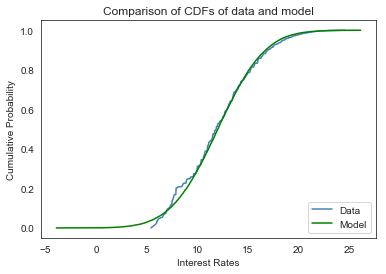

In [29]:
# a plot comparing the cdfs of the data and the model
plt.plot(sorted(data), sorted(data_cdf), color = 'steelblue', label = "Data")
plt.plot(sorted(model), sorted(model_cdf), color = "green", label = "Model")
plt.legend(loc = "lower right")
plt.title("Comparison of CDFs of data and model")
plt.xlabel("Interest Rates")
plt.ylabel("Cumulative Probability")
plt.show()

This is approximately normal. The plot shows that the normal distribution approximates the data well to a certain extent. But, the lower tail of the data deviate from the analytic distribution significantly. However, this data would still provide agreeable and approximately correct results when subjected to tests that expect the input data to follow a normal distribution.

What about the distributions of interest rate segmented by loan status?

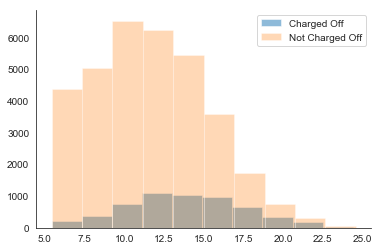

In [14]:
#
plt.hist(loans_final["int_rate"][loans_final.loan_status == "Charged Off"], label = "Charged Off", alpha = 0.5)
plt.hist(loans_final["int_rate"][loans_final.loan_status != "Charged Off"], label = "Not Charged Off", alpha = 0.3)
plt.legend()
sns.despine()
plt.show()

This graph shows that the data follow the normal distribution to a good extent. Though the deviation seems to be greater near the lower tails. But, this can be ignored to a certain extent and some hypothesis tests which expect the data to be normally distributed can be safely carried out on the interest rates.

Another hypothesis that can be tested is whether loans that defaulted have higher interest rates than loans that didn't. A T-test can be safely carried out. But, a more interesting option is a [permutation test](https://thomasleeper.com/Rcourse/Tutorials/permutationtests.html).

Since the permutation test does not make any assumptions about how the data are distributed, it can used safely (to a certain extent). 

The hypothesis to test here would be:

$$H_o: \mu_{Charged Off} = \mu_{Not Charged Off}$$

That is, 

$$H_o: \mu_{Charged Off} - \mu_{Not Charged Off} = 0$$

The research hypothesis would be:

$$H_a: \mu_{Charged Off} \neq \mu_{Not Charged Off}$$

That is, 

$$H_a: \mu_{Charged Off} - \mu_{Not Charged Off} \neq 0$$

Testing this hypothesis at a 5% significance level would give us a good idea of the difference in the data.

In [15]:
# function to find out mean difference
def meanDiff(x, n1, n2):
    n = n1 + n2
    total = np.arange(n)
    indices1 = np.random.choice(n, n1, replace = False)
    indices2 = total[~np.isin(total, indices1)]
    
    mean_diff = x[indices1].mean() - x[indices2].mean()
    return mean_diff

# a function to carry out a permutation test
def permutationTest(x, n1, n2, times= 1000):
    differences = []
    print("Carrying out the permutation test {0} times...".format(times))
    for i in list(range(times)):
        difference = meanDiff(x, n1, n2)
        differences.append(difference)
    
    return differences

In [16]:
# carrying out a permutation test on the interest rates
interest_test_results = permutationTest(x = loans_final["int_rate"], n1 = 5627, n2 = 34090, times = 1000)

Carrying out the permutation test 1000 times...


In [17]:
# finding the actual difference in means
actual_difference = loans_final["int_rate"][loans_final.loan_status == "Charged Off"].mean() - \
loans_final["int_rate"][loans_final.loan_status != "Charged Off"].mean()

Now that both the actual difference and the difference of the permutation test carried out 1000 times, the p-value associated with the test can be calculated.

In [18]:
# p-value associated with the test
sum([i > 0 for i in interest_test_results]) / 1000

0.511

A plot of the distributions of the difference between sample means paints a better picture.

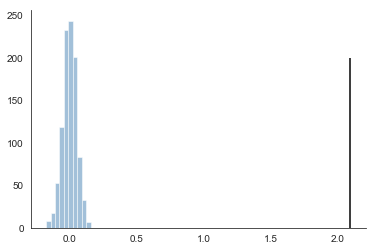

In [19]:
plt.hist(interest_test_results, alpha = 0.5, color = "steelblue")
plt.vlines(x = actual_difference, ymin = 0, ymax = 200)
sns.despine()
plt.show()

The actual difference lies well outside the calculated differences. Thus, we have enough evidence to reject the  null hypothesis that the difference between the means is equal to zero.

## Interest Rate: Results
Here are the results of the analysis of interest rate segmented over loan status.
    1. The distribution of the status of the loan is approximately normal. Thus, hypothesis tests that expect the data to be normally distributed would provide good results.
    2. The difference between the means of interest rates of the loans that did and didn't default is statistically significant. This means that the loans that have defaulted on average have interest rates that are different from loans that didn't default. This information can drive a lot of decisions and could lead to the development of better models.

# Terms of the Loan and Debt-to-income ratio
The next columns of interest would be debt-to-income ratio and term of the loan. The debt-to-income ratio is used by a lot of banks to determine if an applicant has the capaicity to repay a loan. Logically, this would make it a column worth analyzing. 

The term of the loan, directly does not provide us with much information. However, it still does give us information which can be used in some other way.

## Term of the loan
[Include Ranjana's analysis of loans.term]

## Debt-to-income ratio
The dti of is the ratio of the amount of debt a person has to payout in a specified time period to the income they have in the same time period. Usually, the time period is a month. 

dti is an indicator of how able the individual is to repay a loan. Higher values of dti indicate that the person has more debt for his income level. It can be thought of as a standardized measure of the amount of debt a person has.

A good way to start an exploratory analysis of this variable would be look at it's distribution

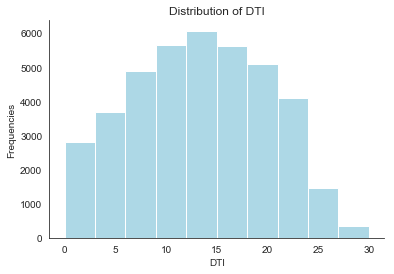

In [20]:
# distribution of dti
plt.hist(loans_final["dti"], color = "lightblue")
plt.title("Distribution of DTI")
plt.xlabel("DTI")
plt.ylabel("Frequencies")
sns.despine()
plt.show()

This seems to have a shape similar to interest rate. So, this might produce a graph that is similar to the one produced by interest rate. So, it's better to move onto the finer details of the segmented analysis.

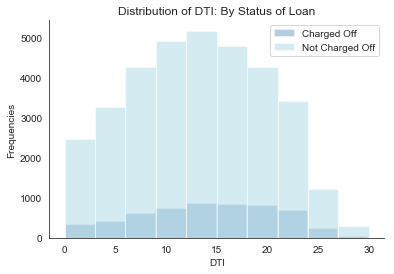

In [21]:
# plot of distributions of dit by loan status
plt.hist(loans_final["dti"][loans_final.loan_status == "Charged Off"], color = "steelblue", 
         label = "Charged Off", alpha = 0.4)
plt.hist(loans_final["dti"][loans_final.loan_status != "Charged Off"], color = "lightblue", 
         label = "Not Charged Off", alpha = 0.5)
plt.title("Distribution of DTI: By Status of Loan")
plt.xlabel("DTI")
plt.ylabel("Frequencies")
plt.legend(loc = "upper right")
sns.despine()
plt.show()

Again, the same question could be asked of dti too? Are the differences statistically significant? A permutation test can be carried. Since a way to do it has already be defined, it's better to check it out...

In [22]:
# permutation test for dti
dti_test_results = permutationTest(x = loans_final["dti"], n1 = 5627, n2 = 34090)

Carrying out the permutation test 1000 times...


In [23]:
actual_diff_dti = loans_final["dti"][loans_final.loan_status == "Charged Off"].mean() - loans_final["dti"][loans_final.loan_status != "Charged Off"].mean()

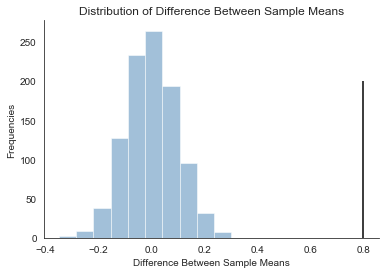

In [24]:
plt.hist(dti_test_results, alpha = 0.5, color = "steelblue")
plt.title("Distribution of Difference Between Sample Means")
plt.xlabel("Difference Between Sample Means")
plt.ylabel("Frequencies")
sns.despine()
plt.vlines(actual_diff_dti, ymin = 0, ymax = 200)

The actual difference lies well outside the calculated difference assuming that the null hypothesis is true. Thus, it's reasonable to conclude that a difference in means of dti does exist for loans that did default and that didn't default.

## Delinquency of Accounts
Delinquency of accounts is a great variable that can be used to determine if an account will default or not. Sadly, the column contains a lot of missing values. And filling those missing values for performing an exploratory analysis might bias our test statistics or the graphs itself. Therefore, even though the column is a potential goldmine, it's pretty useless. 

However, this is one place where we can leverage the power of derived metrics. Is there a way to derive the account delinquency from existing variables? The answer is yes. That is, with reasonable assumptions, a variable similar to account delinquency can be derived from the existing data.

## Terms Ratio
Define terms ratio as the ratio of the number of missed term payments to the total number of terms of the loan. 

$$Terms\ Ratio = \frac{Missed\ Term\ Payments}{Total\ Terms}$$

Missed term payments can be calculated from two other variables: The amount remaining in the loan and the installment of the loan. Again, the amount remaining can be calculated as the difference between the funded amount and the recoveries and the total principal recieved.

$$Missed\ Term\ Payments = \frac{Amount\ Remaining}{Installment}$$

$$Amount\ Remaining = Funded\ Amount - Recoveries - Total\ Principal\ Recieved\ till\ date$$

Thus,
$$ Terms\ Ratio = \frac{Funded\ Amount - Recoveries - Total\ Principal\ Recieved\ till\ date}{Installment * Total Terms}$$

Based on this formula, terms ratio can be derived. From the definition of terms ratio, it is clear that:
    1. A high value of terms ratio cannot be a good sign
    2. A value of 1 indicates that every payment has been missed (a defaulted loan)
    3. A value of 0 indicates that no payments are remaining (a fully paid loan)

By looking at the distribution of terms ratio across loan status, it might be possible to derive some new insight about the data.

### Assumptions made while defining terms ratio:
    1. The loan amounts all have a constant interest installment amortization schedule.
    2. A negative terms ratio indicates that the amount recovered was greater than the amount funded. This will be treated as a fully paid loan.
    3. A terms ratio greater than one is not possible and cannot exist.

In [25]:
# creating the new column terms ratio
## converting term to integer
loans_final["term"] = loans_final["term"].str.extract(r"([0-9][0-9]).*").astype("int16")

## creating terms_ratio
loans_final["terms_ratio"] = (loans_final["funded_amnt"] - loans_final["recoveries"] - loans_final["total_rec_prncp"]) / \
(loans_final["installment"] * loans_final["term"])

In [26]:
# replacing all the negatives in terms_ratio with 0
loans_final.loc[loans_final.terms_ratio < 0, "terms_ratio"] = 0

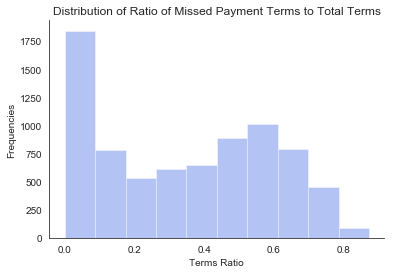

In [27]:
# distribution of terms ratio
# not including 0 since we are not interested in the 0's themselves.
plt.hist(loans_final["terms_ratio"][loans_final.terms_ratio != 0], color = "royalblue", alpha = 0.4)
plt.title("Distribution of Ratio of Missed Payment Terms to Total Terms")
plt.xlabel("Terms Ratio")
plt.ylabel("Frequencies")
sns.despine()
plt.show()

The terms ratio seems to follow an exponential distribution. Thus, it's better to plot the terms ratio as a box plot to get an idea of what the distribution actually looks like.

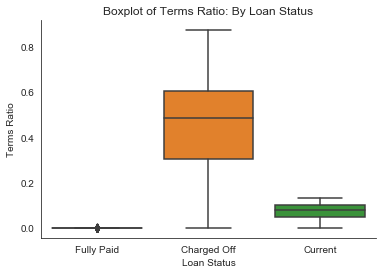

In [28]:
# boxplot of terms ratio over loan status
sns.boxplot(x = "loan_status", y = "terms_ratio", data = loans_final)
plt.title("Boxplot of Terms Ratio: By Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Terms Ratio")
sns.despine()
plt.show()

The boxplot shown above gives us enough information about how terms_ratio varies by loan status. That is, if a person's terms ratio is above a certain value, then there's a good chance that the person is going to default.

## Terms_Ratio and DTI
This might be an interesting relationship to explore. Do people who have higher terms_ratios also have higher dti's? A scatterplot can answer this question.

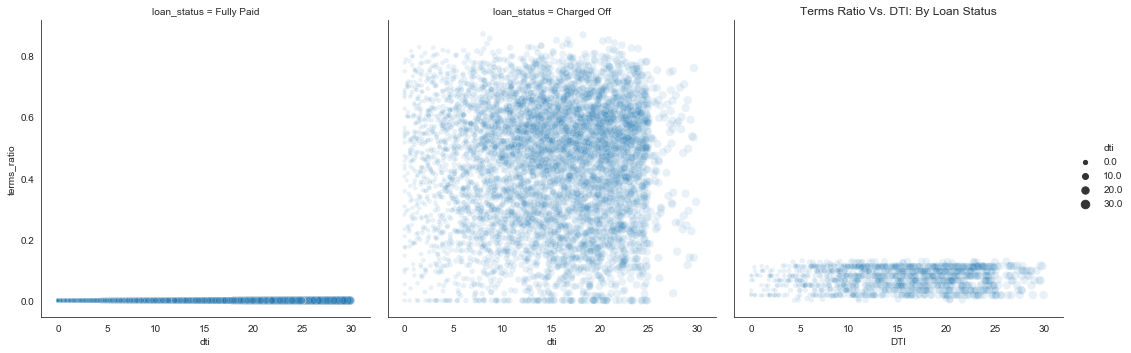

In [32]:
sns.relplot(x = "dti", y = "terms_ratio", col = "loan_status", size = "dti", 
            data = loans_final, kind = "scatter", alpha = 0.1)
plt.title("Terms Ratio Vs. DTI: By Loan Status")
plt.xlabel("DTI")
plt.ylabel("Terms Ratio")
plt.show()

Those mass of points don't reveal a lot of information. But, we can see clearly, patterns in the data. In general for people who had high number of missed term payments were likely to have a high debt to income ratio too.But, the correlation doesn't seem to be too strong. The number might provide justification to this statement.

In [33]:
loans_final["dti"].corr(loans_final["terms_ratio"])

0.04117449004301514

A correlation of only 0.04. That's not a lot. But, it does showcase a weak positive relationship. But, this might not amount to anything. So, any strong conclusions cannot be drawn about the relationship between the number of missed term payments and dti.

# Number of Public Bankruptcies
This is another variable of interest. Common sense tells us that there is a relationship between defaulting and the number of bankruptcies. But, is this true for the given data? Time to find out...

In [35]:
# adding bankruptcies to the mix
loans_final["bankruptcies"] = loans["pub_rec_bankruptcies"]

In [38]:
# description of bankruptcies
loans_final["bankruptcies"].describe()

count    39020.000000
mean         0.043260
std          0.204324
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: bankruptcies, dtype: float64

In [37]:
# info about bankruptcies
loans_final["bankruptcies"].isnull().mean()

0.017549160309187503

Bankruptcies contains about 1.75% missing values. This is not much. Relative to the size of the data, we can impute them with the mode, (since this particular variable has only a few recurring values) or just drop them. Imputing seems to be a better option.

But, dealing with such a skewed distribution might not be for the best as the variable contains a lot of zeros. Converting it into a binary categorical variable might serve the purpose of this analysis better as:
    1. Tests for association become easy
    2. Treating the missing values becomes easy
    3. Information can be packaged more effectively. 
    
Therefore, a new cateogorical variable describing if a person had a bankruptcy in the past will be used in lieu of the numeric variable.

In [39]:
# creating a new variable bankrupt_cat
loans_final["bankrupt_cat"] = "no"
loans_final.loc[loans_final.bankruptcies != 0, "bankrupt_cat"] = "yes"

# creating a new mask to filter out just the na values
mask = ~loans_final["bankruptcies"].isnull()

In [40]:
# pivot table of banruptcies and loan_status
bankruptcies_pt = loans_final.loc[mask, ["bankrupt_cat", "loan_status", "id"]].pivot_table("id", index = "bankrupt_cat", 
                                                                   columns = "loan_status", aggfunc = "count")

In [41]:
# getting the proportions instead of the counts
bankruptcies_props = bankruptcies_pt.reset_index().melt(id_vars = "bankrupt_cat")

Now that the observed frequencies are available in the form of a pivot table, a chi-square test for association can be carried out. The data does not violate any of the assumptions for the test and thus the results obtained can be trusted with a certain degree of confidence.

Before jumping to the test itself, the scipy.stats module needs to be imported to access the chisquare function. Also, defining a function to get the expected frequencies of the categories might help.

In [42]:
# function to get expected frequencies
def getExpFreqs(obs_freqs):
    exp_freqs = np.zeros(obs_freqs.shape)
    total = np.sum(obs_freqs)
    for i in range(obs_freqs.shape[0]):
        row_sum = obs_freqs[i, :].sum()
        for j in range(obs_freqs.shape[1]):
            col_sum = obs_freqs[:, j].sum()
            exp_freqs[i, j] = row_sum * col_sum / total
    return exp_freqs

In [56]:
# getting the result and storing it as a list
f_exp = getExpFreqs(np.array(bankruptcies_pt)).tolist()

# flattening the list
f_exp = [item for sublist in f_exp for item in sublist]

# getting the observed frequencies
f_obs = [item for sublist in np.array(bankruptcies_pt).tolist() for item in sublist]

In [47]:
# importing scipy.stats for the chisquare function
import scipy.stats as sps

In [58]:
sps.chisquare(f_obs = f_obs, 
              f_exp = f_exp)

Power_divergenceResult(statistic=88.25019731203567, pvalue=1.5659705474440515e-17)

The critical value at this particular significance level is 5.9. The calculated statistic is 88. So, the null hypothesis that there is no association between the two variables can be rejected and the alternate hypothesis that there is some association between having a bankruptcy and defaulting can be established.